#Imports and functions

In [ ]:
%matplotlib inline

import pandas as pd
import numpy as np
import os
import random
import warnings
import cv2
import math
from PIL import Image
warnings.filterwarnings('ignore')

import seaborn as sns
import matplotlib.pyplot as plt
import scipy

from sklearn.utils import shuffle

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

from google.colab.patches import cv2_imshow
from skimage.feature import hog

plt.rcParams['figure.figsize'] = 6, 4
plt.style.use('ggplot')

%config InlineBackend.figure_format = 'svg'

In [ ]:
import torch
import random

import torchvision
import time
import copy

import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torchvision import transforms, models

RANDOM_STATE = 42

random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)
torch.cuda.manual_seed(RANDOM_STATE)
torch.backends.cudnn.deterministic = True

In [ ]:
from zipfile import ZipFile
from google.colab import drive

drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [ ]:
# Display random images
def display_random_images(images, labels, num_images, grid_size=(4, 5)):

    '''Display some images with labels from the dataset '''

    num_rows, num_cols = grid_size
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 10))

    indices = random.sample(range(len(images)), num_images)
    for i, idx in enumerate(indices):
        image = images[idx]
        label = labels[idx]

        row = i // num_cols
        col = i % num_cols
        ax = axes[row, col] if num_rows > 1 else axes[col]
        ax.imshow(image)
        ax.set_title(label)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
import shutil
from tqdm import tqdm

def train_model(model, criterion, optimizer, scheduler, num_epochs):

  """
    Trains a PyTorch model for a given number of epochs using the provided criterion, optimizer, and learning rate scheduler.

    Args:
    - model: a PyTorch model
    - criterion: a loss function to be used during training
    - optimizer: an optimizer to be used during training
    - scheduler: a learning rate scheduler
    - num_epochs: the number of training epochs

    Returns:
    - model: the trained PyTorch model
    - train_losses: a list of training losses for each epoch
    - train_accs: a list of training accuracies for each epoch (or r2 score for regression task)
    - val_losses: a list of validation losses for each epoch
    - val_accs: a list of validation accuracies for each epoch (or r2 score for regression task)
    """

  # Define early stopping
  best_test_loss = np.inf
  patience = 10
  counter = 0

  # Train the model
  train_losses = []
  val_losses = []

  train_accs = []
  val_accs = []

  for epoch in range(num_epochs):
      print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)

      # Initialize running loss and accuracy
      running_loss = 0.0
      running_acc = 0.0

      # Loop over training data
      for inputs, targets in tqdm(train_loader):
          # Move inputs and targets to device
          inputs = inputs.to(device)
          targets = targets.to(device)

          # Zero the gradients
          optimizer.zero_grad()

          # Forward pass
          outputs = model(inputs)

          # Compute loss
          loss = criterion(outputs, targets)

          # Backward pass
          loss.backward()

          # Update parameters
          optimizer.step()

          # Update running loss
          running_loss += loss.item()

          outputs_class = outputs.argmax(dim=1)
          running_acc += (outputs_class == targets.data).float().mean().item()

      avg_train_loss = running_loss/len(train_loader)
      train_losses.append(avg_train_loss)

      avg_train_acc = running_acc/len(train_loader)
      train_accs.append(avg_train_acc)

      print('Train Loss: {:.4f}'.format(avg_train_loss), flush=True)

      # Evaluate the model on validation data
      model.eval()
      with torch.no_grad():
          test_loss = 0.0
          test_acc = 0.0

          y_true = []
          y_pred = []
          for inputs, targets in tqdm(val_loader):
              inputs = inputs.to(device)
              targets = targets.to(device)

              outputs = model(inputs)
              test_loss += criterion(outputs, targets).item()
              y_true.extend(targets.tolist())
              y_pred.extend(outputs.argmax(dim=1))#.squeeze().tolist())

              test_acc += (outputs.argmax(dim=1) == targets.data).float().mean().item()

          avg_test_loss = test_loss/len(val_loader)
          val_losses.append(avg_test_loss)

          avg_test_acc = test_acc/len(val_loader)
          val_accs.append(avg_test_acc)

          print('Val Loss: {:.4f}'.format(avg_test_loss), flush=True)

          # Update the learning rate scheduler
          scheduler.step(avg_test_loss)

          # Check if the current test loss is the best so far
          if avg_test_loss < best_test_loss:
              best_test_loss = avg_test_loss
              counter = 0
          else:
              counter += 1

          # Check if early stopping criteria are met
          if counter >= patience:
              print(f'Early stopping after {epoch+1} epochs.')
              break

  return model, train_losses, train_accs, val_losses, val_accs


def test_model(model, criterion):

  """
  Tests a PyTorch model for a given number of epochs using the provided criterion.

  Args:
  - model: a PyTorch model
  - criterion: a loss function to be used during training

  Returns:
  - y_true: input targets
  - y_pred: predicted classes
  """

  model.eval()
  with torch.no_grad():
      test_loss = 0.0
      y_true = []
      y_pred = []
      for inputs, targets in tqdm(test_loader):
          inputs = inputs.to(device)
          targets = targets.to(device)

          outputs = model(inputs)

          test_loss += criterion(outputs, targets).item()
          y_true.extend(targets.tolist())
          y_pred.extend(outputs.argmax(dim=1).squeeze().tolist())

      avg_test_loss = test_loss/len(test_loader)
      print('Test Loss: {:.4f}'.format(avg_test_loss))

      print(classification_report(y_true, y_pred))
      print(confusion_matrix(y_true, y_pred))

      return y_true, y_pred

In [ ]:
def print_confusion_matrix(y_true, y_pred):

  ''' Visualize the confusion matrix normalized by class sizes '''

  cf_matrix = confusion_matrix(y_true,y_pred)
  sns.heatmap(cf_matrix,
            annot = cf_matrix / np.sum(cf_matrix, axis=1),
            cmap=sns.color_palette("Blues", as_cmap=True)
  )
  plt.show()

#Data

Let's extract the data.

In [ ]:
import zipfile
with zipfile.ZipFile('/content/gdrive/MyDrive/EPAM_CV/Classification_data.zip', 'r') as zip_obj:
   # Extract all the contents of zip file in current directory
   zip_obj.extractall('/content/')

print('After zip extraction:')
print(os.listdir("/content/"))

After zip extraction:
['.config', 'Classification_data', 'gdrive', 'ultralytics', 'sample_data']


Now let's take a look at the `Classification_data` directory. We can see two subdirectories: one with training data and another one with the data for testing.

In [ ]:
data_root = '/content/Classification_data/'
print(os.listdir(data_root))

['train', 'test']


We can see that we have 6 classes: 'street', 'forest', 'sea', 'glacier', 'mountain' and 'buildings'.


In [ ]:
train_path = f'{data_root}train'
test_path = f'{data_root}test'

labels = os.listdir(train_path)
labels

['sea', 'mountain', 'forest', 'buildings', 'street', 'glacier']

In [ ]:
# Define variables to store cumulative statistics
total_images = 0
total_width = 0
total_height = 0
max_width = 0
max_height = 0
min_width = float('inf')
min_height = float('inf')

width_list = []
height_list = []

# Iterate over each folder
for label in labels:
    label_path = os.path.join(train_path, label)
    if os.path.exists(label_path) and os.path.isdir(label_path):
        # Iterate over each file in the folder
        for filename in os.listdir(label_path):
            file_path = os.path.join(label_path, filename)
            if os.path.isfile(file_path):
                try:
                    # Open the image and get its size
                    img = Image.open(file_path)
                    width, height = img.size

                    # Update statistics
                    total_images += 1
                    total_width += width
                    total_height += height
                    max_width = max(max_width, width)
                    max_height = max(max_height, height)
                    min_width = min(min_width, width)
                    min_height = min(min_height, height)

                    # Append width and height to the respective lists
                    width_list.append(width)
                    height_list.append(height)

                except (IOError, OSError):
                    print(f"Error opening image: {file_path}")

# Calculate average width and height
average_width = total_width / total_images
average_height = total_height / total_images

# Calculate standard deviation of width and height
sum_squared_width_diff = sum((width - average_width) ** 2 for width in width_list)
sum_squared_height_diff = sum((height - average_height) ** 2 for height in height_list)
width_std_deviation = math.sqrt(sum_squared_width_diff / total_images)
height_std_deviation = math.sqrt(sum_squared_height_diff / total_images)

# Print the statistics
print(f"Total images: {total_images}")
print(f"Average width: {average_width} pixels")
print(f"Average height: {average_height} pixels")
print(f"Maximum width: {max_width} pixels")
print(f"Maximum height: {max_height} pixels")
print(f"Minimum width: {min_width} pixels")
print(f"Minimum height: {min_height} pixels")
print(f"Width standard deviation: {width_std_deviation:.2f} pixels")
print(f"Height standard deviation: {height_std_deviation:.2f} pixels")

Total images: 14034
Average width: 150.0 pixels
Average height: 149.90872167592988 pixels
Maximum width: 150 pixels
Maximum height: 150 pixels
Minimum width: 150 pixels
Minimum height: 76 pixels
Width standard deviation: 0.00 pixels
Height standard deviation: 1.87 pixels


Now I'd like to place images with their corresponding labels into separate arrays. I will resize each image to a single size. As wee see from the statistics, width of all of the images is 150, height ranges from 76 to 150 pixels, equal to 150 in most of the images. For model with classical features I'll pick the size 100x100 so as not to reach memory limit, for CNN models I'll convert images to a size of 150x150.

In [ ]:
# Initialize lists for storing train and test images and labels
train_images = []
train_labels = []
test_images = []
test_labels = []
sizes = set()

# Iterate over the labels
for label in labels:
    # Get the paths to the image files in the train and test subfolders
    train_label_folder = os.path.join(train_path, label)
    train_image_files = os.listdir(train_label_folder)

    test_label_folder = os.path.join(test_path, label)
    test_image_files = os.listdir(test_label_folder)

    # Load train images and labels
    for train_image_file in train_image_files:
        train_image_path = os.path.join(train_label_folder, train_image_file)
        train_image = cv2.imread(train_image_path)
        train_image = cv2.resize(train_image, (100, 100)).astype(np.uint8)
        train_image = cv2.cvtColor(train_image, cv2.COLOR_BGR2RGB)
        train_images.append(train_image)
        train_labels.append(label)
        sizes.add(train_image.shape)

    # Load test images and labels
    for test_image_file in test_image_files:
        test_image_path = os.path.join(test_label_folder, test_image_file)
        test_image = cv2.imread(test_image_path)
        test_image = cv2.resize(test_image, (100, 100)).astype(np.uint8)
        test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
        test_images.append(test_image)
        test_labels.append(label)
        sizes.add(train_image.shape)

# Convert the lists to numpy arrays
train_images = np.array(train_images)
train_labels = np.array(train_labels)
test_images = np.array(test_images)
test_labels = np.array(test_labels)

# Print the shapes of the train and test data
print("Train images shape:", train_images.shape)
print("Train labels shape:", train_labels.shape)
print("Test images shape:", test_images.shape)
print("Test labels shape:", test_labels.shape)

Train images shape: (14034, 100, 100, 3)
Train labels shape: (14034,)
Test images shape: (3000, 100, 100, 3)
Test labels shape: (3000,)


 I'd like randomize the order of the train_images and train_labels arrays in order to avoid biases in the training process.

In [ ]:
train_images, train_labels = shuffle(train_images, train_labels, random_state=RANDOM_STATE)

#EDA

Let's display some images from the dataset.

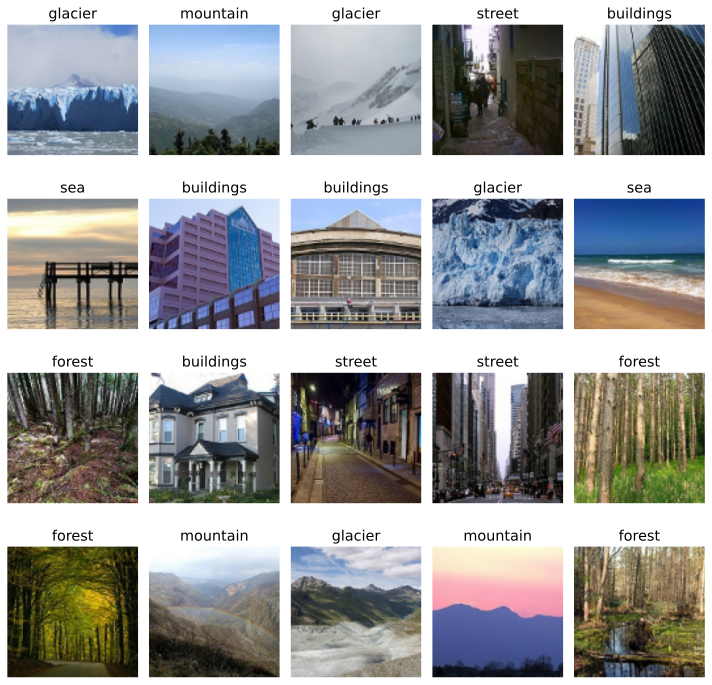

In [ ]:
display_random_images(train_images, train_labels, num_images=20)

The dataset is balanced.

<Axes: ylabel='count'>

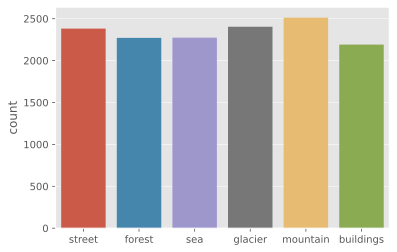

In [ ]:
sns.countplot(x=train_labels)

To extract features from the image we can apply different algorithms such as Local Binary Patterns (LBP) for texture patterns, Scale-Invariant Feature Transform (SIFT) for scale and rotation invariance, Histogram of Oriented Gradients (HOG) for edge and shape information. In addition, pixel values of color or grayscale image, as well as histograms, can be used as features in non-CNN classifiers.

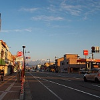

In [ ]:
img = train_images[0]
cv2_imshow(cv2.cvtColor(img, cv2.COLOR_RGB2BGR))

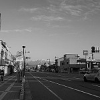

In [ ]:
gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
cv2_imshow(gray_img)

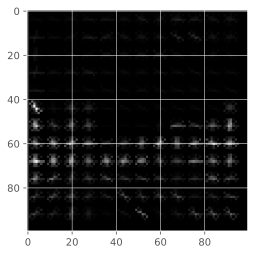

In [ ]:
hog_features, hog_image = hog(gray_img, visualize=True)
plt.imshow(hog_image, cmap=plt.cm.gray)

#Models

Let's first encode the targets.

In [ ]:
le = LabelEncoder()
y_train = le.fit_transform(train_labels)
y_test = le.fit_transform(test_labels)

##Classical features + SVM classificator (color pixels + hog)

It has been experimentally found that using color image pixel values and oriented gradients histogram (HOG) functions gives better results than other feature sets. Given the pixel values, the model can get the raw color information, while the HOG functions provide a representation of the edge and shape characteristics.

In [ ]:
def make_multiple_image_features(images):
    features_list = [np.concatenate((img.flatten(), hog(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)))) for img in images]
    return np.vstack(features_list).astype(np.float32)


X_train = make_multiple_image_features(train_images)
X_test = make_multiple_image_features(test_images)

In [ ]:
import gc
gc.collect()

58

Let's scale the features.

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
X_train[0].shape

(38100,)

We see that our dataset has 38100 features. To reduce their number, I will apply PCA.

In [ ]:
pca = PCA(n_components=7000)

X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

As a model, I'll use SVM with linear kernel.

In [ ]:
svm = SVC(kernel='linear', probability=True)
svm.fit(X_train, y_train)

SVC(kernel='linear', probability=True)

The model gives 70% accuracy.

In [ ]:
y_pred = svm.predict(X_test)
accuracy_score(y_test, y_pred)

0.707

Let's take a look at other metrics such as precision, recall and confusion matrix.

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.69      0.71      0.70       437
           1       0.89      0.91      0.90       474
           2       0.62      0.65      0.64       553
           3       0.62      0.65      0.63       525
           4       0.66      0.60      0.63       510
           5       0.79      0.75      0.77       501

    accuracy                           0.71      3000
   macro avg       0.71      0.71      0.71      3000
weighted avg       0.71      0.71      0.71      3000



In [ ]:
confusion_matrix(y_test, y_pred)

array([[309,  15,  15,  17,  19,  62],
       [  7, 430,   5,   3,   3,  26],
       [ 14,   5, 362, 104,  62,   6],
       [ 16,   7, 100, 339,  60,   3],
       [ 19,   5,  91,  84, 306,   5],
       [ 80,  20,  11,   4,  11, 375]])

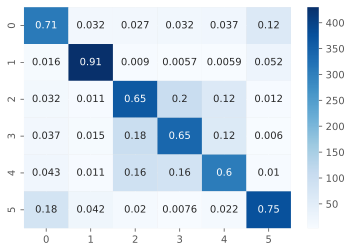

In [ ]:
print_confusion_matrix(y_test, y_pred)

Based on the given confusion matrix, we can observe that there are significant misclassifications among the following classes: glacier, mountain, and sea. Additionally, there are some misclassifications between buildings and streets. Since these classes are quite similar visually, it is expected to have these missclassifications.

##Classical features + SVM classificator (color histograms + hog)

Let's try another set of features: color histograms + hog.

In [ ]:
def make_multiple_image_features(images, num_bins=256):
    features_list = []
    for img in images:
        # Calculate color histogram
        hist = np.empty((0,))
        for channel in cv2.split(img):
            hist_channel = cv2.calcHist([channel], [0], None, [num_bins], [0, num_bins])
            hist = np.concatenate((hist, hist_channel.flatten()))

         # Calculate HOG features
        hog_features = hog(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY))

        # Concatenate histogram and HOG features
        combined_features = np.concatenate((hist, hog_features))

        # Append combined features to the features list
        features_list.append(combined_features)

    # Stack all the features vertically and convert to float32
    return np.vstack(features_list).astype(np.float32)

X_train = make_multiple_image_features(train_images)
X_test = make_multiple_image_features(test_images)

Let's scale the features.

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
X_train[0].shape

(8868,)

As a model, I'll use SVM with linear kernel.

In [ ]:
svm = SVC(kernel='linear', probability=True)
svm.fit(X_train, y_train)

SVC(kernel='linear', probability=True)

The model gives 68% accuracy.

In [ ]:
y_pred = svm.predict(X_test)
accuracy_score(y_test, y_pred)

0.681

Let's take a look at other metrics such as precision, recall and confusion matrix.

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.67      0.71      0.69       437
           1       0.90      0.93      0.91       474
           2       0.59      0.65      0.62       553
           3       0.55      0.53      0.54       525
           4       0.63      0.55      0.59       510
           5       0.78      0.74      0.76       501

    accuracy                           0.68      3000
   macro avg       0.69      0.69      0.68      3000
weighted avg       0.68      0.68      0.68      3000



In [ ]:
confusion_matrix(y_test, y_pred)

array([[311,   9,  13,  11,  16,  77],
       [  8, 442,   5,   5,   0,  14],
       [ 14,   6, 361, 115,  53,   4],
       [ 18,   9, 134, 278,  81,   5],
       [ 32,   5,  94,  93, 282,   4],
       [ 82,  22,   9,   5,  14, 369]])

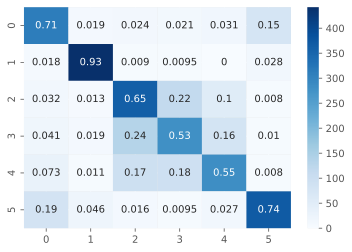

In [ ]:
print_confusion_matrix(y_test, y_pred)

##CNN

Now, let's proceed to the implementation of CNN models using PyTorch for training. First we need to define data transformations for training and testing images and then create image datasets using the specified transformations.

In [ ]:
# train_transforms = transforms.Compose([
#     transforms.Resize((150, 150)),
#     transforms.RandomHorizontalFlip(),
#     transforms.ToTensor(),
#     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
# ])

train_transforms = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.RandomApply([
        transforms.RandomRotation(20),              # Apply random rotation (±30 degrees)
        transforms.RandomHorizontalFlip(),         # Randomly flip the image horizontally
        transforms.ColorJitter(brightness=0.2,     # Randomly adjust brightness, contrast, and saturation
                               contrast=0.2,
                               saturation=0.2),
    ], p=0.5),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


train_dataset = torchvision.datasets.ImageFolder(train_path, train_transforms)
test_dataset = torchvision.datasets.ImageFolder(test_path, test_transforms)

In [ ]:
train_dataset

Dataset ImageFolder
    Number of datapoints: 14034
    Root location: /content/Classification_data/train
    StandardTransform
Transform: Compose(
               Resize(size=(150, 150), interpolation=bilinear, max_size=None, antialias=warn)
               RandomApply(
               p=0.5
               RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)
               RandomHorizontalFlip(p=0.5)
               ColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2), saturation=(0.8, 1.2), hue=None)
           )
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [ ]:
test_dataset

Dataset ImageFolder
    Number of datapoints: 3000
    Root location: /content/Classification_data/test
    StandardTransform
Transform: Compose(
               Resize(size=(150, 150), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

The part of train images I'll use for validation.

In [ ]:
generator = torch.Generator().manual_seed(42)
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [12034, 2000], generator = generator)

In [ ]:
val_dataset.transform = test_transforms

In [ ]:
val_dataset.transform

Compose(
    Resize(size=(150, 150), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

I'll create data loaders with a batch size 16, enabling parallel processing and shuffling of the training data while keeping the validation and testing data in their original order.

In [ ]:
batch_size = 16
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=batch_size)
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=batch_size)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=batch_size)

I'll perform the computations on GPU.

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

###CNN with custom architecture

Here I define a custom classifier model that consists of several convolutional layers with batch-normalization, max pooling layers, and a linear layer.

In [ ]:
class Classifier(torch.nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()


        self.c1 = self.conv(3, 64)
        self.c2 = self.conv(64, 128)
        self.c3 = self.conv(128, 256)
        self.c4 = self.conv(256, 256)
        self.c5 = self.conv(256, 128)
        self.lastcnn = torch.nn.Conv2d(in_channels=128, out_channels=6, kernel_size=18, stride=1, padding=0)

        self.maxpool = torch.nn.MaxPool2d(kernel_size=2, stride=2)

        self.linear = torch.nn.Linear(1, 6)


    def forward(self, x):
        x = self.c1(x)
        x = self.maxpool(x)

        x = self.c2(x)
        x = self.maxpool(x)

        x = self.c3(x)

        x = self.c4(x)
        x = self.maxpool(x)

        x = self.c5(x)
        x = self.lastcnn(x)

        x = x.squeeze()

        return x


    def conv(self, ch_in, ch_out, kernel_size=3, stride=1, padding=1):
        seq_block = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=ch_in, out_channels=ch_out, kernel_size=kernel_size, stride=stride, padding=padding),
            torch.nn.BatchNorm2d(num_features=ch_out),
            torch.nn.ReLU(),
        )

        return seq_block

Now we can create an instance of the Classifier model, move it to the GPU, define a loss function, an optimizer for parameter optimization (I'll use Adam), a learning rate scheduler, and then train the model.

In [ ]:
model = Classifier()

model = model.to(device)

loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

model, train_loss, val_loss, train_acc, val_acc = train_model(model, loss, optimizer, scheduler, 50)

Epoch 0/49:


100%|██████████| 753/753 [00:27<00:00, 27.45it/s]

Train Loss: 2.0413



100%|██████████| 125/125 [00:03<00:00, 40.38it/s]

Val Loss: 0.8811
Epoch 1/49:



100%|██████████| 753/753 [00:19<00:00, 38.04it/s]

Train Loss: 0.7414



100%|██████████| 125/125 [00:02<00:00, 48.08it/s]

Val Loss: 0.6457
Epoch 2/49:



100%|██████████| 753/753 [00:17<00:00, 43.56it/s]

Train Loss: 0.5984



100%|██████████| 125/125 [00:02<00:00, 47.93it/s]

Val Loss: 0.5251
Epoch 3/49:



100%|██████████| 753/753 [00:17<00:00, 42.89it/s]

Train Loss: 0.5301



100%|██████████| 125/125 [00:02<00:00, 48.00it/s] 

Val Loss: 0.5841
Epoch 4/49:



100%|██████████| 753/753 [00:17<00:00, 43.30it/s]

Train Loss: 0.4831



100%|██████████| 125/125 [00:02<00:00, 49.74it/s] 

Val Loss: 0.5286
Epoch 5/49:



100%|██████████| 753/753 [00:17<00:00, 43.03it/s]

Train Loss: 0.4443



100%|██████████| 125/125 [00:03<00:00, 32.29it/s]

Val Loss: 0.6255
Epoch 6/49:



100%|██████████| 753/753 [00:18<00:00, 41.55it/s]

Train Loss: 0.4068



100%|██████████| 125/125 [00:02<00:00, 46.76it/s]

Val Loss: 0.4629
Epoch 7/49:



100%|██████████| 753/753 [00:17<00:00, 42.96it/s]

Train Loss: 0.3815



100%|██████████| 125/125 [00:03<00:00, 40.33it/s]

Val Loss: 0.4616
Epoch 8/49:



100%|██████████| 753/753 [00:17<00:00, 42.32it/s]

Train Loss: 0.3451



100%|██████████| 125/125 [00:02<00:00, 44.68it/s]

Val Loss: 0.4876
Epoch 9/49:



100%|██████████| 753/753 [00:17<00:00, 43.27it/s]

Train Loss: 0.3180



100%|██████████| 125/125 [00:02<00:00, 46.70it/s]

Val Loss: 0.4451
Epoch 10/49:



100%|██████████| 753/753 [00:17<00:00, 42.85it/s]

Train Loss: 0.2723



100%|██████████| 125/125 [00:02<00:00, 48.37it/s]

Val Loss: 0.4594
Epoch 11/49:



100%|██████████| 753/753 [00:17<00:00, 43.32it/s]

Train Loss: 0.2400



100%|██████████| 125/125 [00:02<00:00, 48.48it/s]

Val Loss: 0.5028
Epoch 12/49:



100%|██████████| 753/753 [00:17<00:00, 43.09it/s]

Train Loss: 0.2165



100%|██████████| 125/125 [00:03<00:00, 40.53it/s]

Val Loss: 0.5204
Epoch 13/49:



100%|██████████| 753/753 [00:17<00:00, 42.79it/s]

Train Loss: 0.1738



100%|██████████| 125/125 [00:02<00:00, 47.77it/s] 

Val Loss: 0.5611
Epoch 14/49:



100%|██████████| 753/753 [00:17<00:00, 43.27it/s]

Train Loss: 0.1458



100%|██████████| 125/125 [00:03<00:00, 40.55it/s]

Val Loss: 0.5631
Epoch 15/49:



100%|██████████| 753/753 [00:17<00:00, 43.12it/s]

Train Loss: 0.1370



100%|██████████| 125/125 [00:02<00:00, 47.47it/s]

Val Loss: 0.5862
Epoch 16/49:



100%|██████████| 753/753 [00:17<00:00, 43.32it/s]

Train Loss: 0.1339



100%|██████████| 125/125 [00:02<00:00, 47.72it/s] 

Val Loss: 0.6597
Epoch 17/49:



100%|██████████| 753/753 [00:19<00:00, 38.34it/s]

Train Loss: 0.1110



100%|██████████| 125/125 [00:02<00:00, 42.32it/s]

Val Loss: 0.6506
Epoch 18/49:



100%|██████████| 753/753 [00:17<00:00, 43.23it/s]

Train Loss: 0.0931



100%|██████████| 125/125 [00:02<00:00, 46.26it/s] 

Val Loss: 0.7009
Epoch 19/49:



100%|██████████| 753/753 [00:17<00:00, 42.99it/s]

Train Loss: 0.0860



100%|██████████| 125/125 [00:02<00:00, 43.48it/s] 

Val Loss: 0.7894
Early stopping after 20 epochs.


Let's see the results.

In [ ]:
y_true, y_pred = test_model(model, loss)

100%|██████████| 188/188 [00:03<00:00, 56.71it/s] 

Test Loss: 0.7530
              precision    recall  f1-score   support

           0       0.76      0.84      0.80       437
           1       0.93      0.97      0.95       474
           2       0.75      0.82      0.78       553
           3       0.79      0.78      0.78       525
           4       0.88      0.83      0.85       510
           5       0.89      0.75      0.81       501

    accuracy                           0.83      3000
   macro avg       0.83      0.83      0.83      3000
weighted avg       0.83      0.83      0.83      3000

[[369   8   7   5  11  37]
 [  1 458   3   5   2   5]
 [  8   3 452  72  17   1]
 [  9   3  86 408  19   0]
 [ 13   5  46  22 421   3]
 [ 84  17  12   4   9 375]]


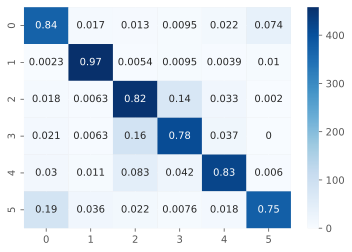

In [ ]:
print_confusion_matrix(y_true, y_pred)

As expected, custom CNN performs better than SVM with classical features.

###Pretrained CNN

Now let's try pretrained models.

####ResNet (with old augmentstions)

In [ ]:
model = models.resnet18(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

model.fc = torch.nn.Linear(model.fc.in_features, 6)

model = model.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

model, train_losses, train_accs, val_losses, val_accs = train_model(model, criterion, optimizer, scheduler, 12)

Epoch 0/11:


100%|██████████| 753/753 [00:20<00:00, 37.22it/s]

Train Loss: 0.5437



100%|██████████| 125/125 [00:02<00:00, 43.62it/s]

Val Loss: 0.3150
Epoch 1/11:



100%|██████████| 753/753 [00:10<00:00, 68.75it/s] 

Train Loss: 0.3112



100%|██████████| 125/125 [00:02<00:00, 53.12it/s] 

Val Loss: 0.3089
Epoch 2/11:



100%|██████████| 753/753 [00:12<00:00, 61.83it/s] 

Train Loss: 0.2871



100%|██████████| 125/125 [00:02<00:00, 51.97it/s] 

Val Loss: 0.2896
Epoch 3/11:



100%|██████████| 753/753 [00:10<00:00, 69.29it/s]

Train Loss: 0.2773



100%|██████████| 125/125 [00:02<00:00, 50.31it/s] 

Val Loss: 0.3081
Epoch 4/11:



100%|██████████| 753/753 [00:13<00:00, 55.82it/s] 

Train Loss: 0.2683



100%|██████████| 125/125 [00:02<00:00, 47.72it/s]

Val Loss: 0.3095
Epoch 5/11:



100%|██████████| 753/753 [00:11<00:00, 67.62it/s]

Train Loss: 0.2657



100%|██████████| 125/125 [00:03<00:00, 41.66it/s] 

Val Loss: 0.3618
Epoch 6/11:



100%|██████████| 753/753 [00:11<00:00, 64.78it/s]

Train Loss: 0.2621



100%|██████████| 125/125 [00:02<00:00, 48.91it/s] 

Val Loss: 0.3161
Epoch 7/11:



100%|██████████| 753/753 [00:11<00:00, 64.37it/s]

Train Loss: 0.2561



100%|██████████| 125/125 [00:02<00:00, 42.09it/s]

Val Loss: 0.3042
Epoch 8/11:



100%|██████████| 753/753 [00:10<00:00, 70.94it/s] 

Train Loss: 0.2538



100%|██████████| 125/125 [00:02<00:00, 48.52it/s]

Val Loss: 0.3171
Epoch 9/11:



100%|██████████| 753/753 [00:11<00:00, 63.34it/s]

Train Loss: 0.2485



100%|██████████| 125/125 [00:02<00:00, 50.06it/s] 

Val Loss: 0.3204
Epoch 10/11:



100%|██████████| 753/753 [00:10<00:00, 72.52it/s] 

Train Loss: 0.2455



100%|██████████| 125/125 [00:02<00:00, 47.06it/s] 

Val Loss: 0.3126
Epoch 11/11:



100%|██████████| 753/753 [00:10<00:00, 72.45it/s]

Train Loss: 0.2419



100%|██████████| 125/125 [00:02<00:00, 46.18it/s] 

Val Loss: 0.3129


In [ ]:
y_true, y_pred = test_model(model, criterion)

100%|██████████| 188/188 [00:03<00:00, 58.71it/s] 

Test Loss: 0.3004
              precision    recall  f1-score   support

           0       0.90      0.91      0.91       437
           1       0.99      0.98      0.99       474
           2       0.85      0.76      0.80       553
           3       0.80      0.85      0.82       525
           4       0.92      0.95      0.94       510
           5       0.91      0.92      0.92       501

    accuracy                           0.89      3000
   macro avg       0.90      0.90      0.90      3000
weighted avg       0.89      0.89      0.89      3000

[[398   0   1   3   0  35]
 [  2 465   2   3   0   2]
 [  2   4 422  95  27   3]
 [  0   0  64 446  13   2]
 [  3   0   7  13 486   1]
 [ 36   0   0   1   2 462]]


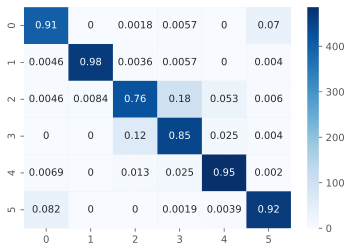

In [ ]:
print_confusion_matrix(y_true, y_pred)

The model gives about 90% accuracy.

####ResNet (with new augmentations)

In [ ]:
model = models.resnet18(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

model.fc = torch.nn.Linear(model.fc.in_features, 6)

model = model.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

model, train_losses, train_accs, val_losses, val_accs = train_model(model, criterion, optimizer, scheduler, 12)

Epoch 0/11:


100%|██████████| 753/753 [00:14<00:00, 51.75it/s]

Train Loss: 0.6226



100%|██████████| 125/125 [00:02<00:00, 43.07it/s]

Val Loss: 0.3913
Epoch 1/11:



100%|██████████| 753/753 [00:14<00:00, 52.81it/s] 

Train Loss: 0.3836



100%|██████████| 125/125 [00:03<00:00, 40.78it/s]

Val Loss: 0.3825
Epoch 2/11:



100%|██████████| 753/753 [00:14<00:00, 53.56it/s] 

Train Loss: 0.3541



100%|██████████| 125/125 [00:02<00:00, 41.83it/s] 

Val Loss: 0.3365
Epoch 3/11:



100%|██████████| 753/753 [00:13<00:00, 54.47it/s]

Train Loss: 0.3496



100%|██████████| 125/125 [00:03<00:00, 34.40it/s]

Val Loss: 0.3342
Epoch 4/11:



100%|██████████| 753/753 [00:14<00:00, 53.52it/s]

Train Loss: 0.3310



100%|██████████| 125/125 [00:02<00:00, 41.68it/s]

Val Loss: 0.3324
Epoch 5/11:



100%|██████████| 753/753 [00:14<00:00, 52.99it/s]

Train Loss: 0.3353



100%|██████████| 125/125 [00:03<00:00, 41.13it/s]

Val Loss: 0.3321
Epoch 6/11:



100%|██████████| 753/753 [00:14<00:00, 53.01it/s]

Train Loss: 0.3297



100%|██████████| 125/125 [00:02<00:00, 42.32it/s]

Val Loss: 0.3684
Epoch 7/11:



100%|██████████| 753/753 [00:14<00:00, 52.14it/s] 

Train Loss: 0.3251



100%|██████████| 125/125 [00:02<00:00, 42.31it/s] 

Val Loss: 0.3400
Epoch 8/11:



100%|██████████| 753/753 [00:14<00:00, 53.31it/s] 

Train Loss: 0.3179



100%|██████████| 125/125 [00:03<00:00, 40.19it/s]

Val Loss: 0.3495
Epoch 9/11:



100%|██████████| 753/753 [00:13<00:00, 54.80it/s]

Train Loss: 0.3104



100%|██████████| 125/125 [00:03<00:00, 36.43it/s]

Val Loss: 0.3293
Epoch 10/11:



100%|██████████| 753/753 [00:14<00:00, 52.70it/s]

Train Loss: 0.3251



100%|██████████| 125/125 [00:02<00:00, 42.88it/s]

Val Loss: 0.3439
Epoch 11/11:



100%|██████████| 753/753 [00:14<00:00, 52.98it/s]

Train Loss: 0.3110



100%|██████████| 125/125 [00:02<00:00, 41.97it/s]

Val Loss: 0.3508


In [ ]:
y_true, y_pred = test_model(model, criterion)

100%|██████████| 188/188 [00:03<00:00, 58.67it/s] 

Test Loss: 0.3012
              precision    recall  f1-score   support

           0       0.90      0.91      0.90       437
           1       0.98      0.99      0.99       474
           2       0.81      0.83      0.82       553
           3       0.84      0.80      0.82       525
           4       0.93      0.94      0.93       510
           5       0.92      0.91      0.91       501

    accuracy                           0.89      3000
   macro avg       0.90      0.90      0.90      3000
weighted avg       0.89      0.89      0.89      3000

[[399   0   0   2   0  36]
 [  0 468   2   2   0   2]
 [  2   5 459  64  22   1]
 [  1   1  87 419  15   2]
 [  3   0  15  10 481   1]
 [ 40   2   1   1   2 455]]


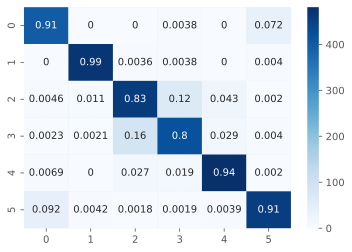

In [ ]:
print_confusion_matrix(y_true, y_pred)

The model gives about 90% accuracy.

####YOLO

In [ ]:
from IPython.display import Image
from collections import defaultdict

In [ ]:
# TODO: clone release branch when available
!git clone https://github.com/ultralytics/ultralytics
%cd ultralytics
%pip install -e '.[dev]'

fatal: destination path 'ultralytics' already exists and is not an empty directory.
/content/ultralytics
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining file:///content/ultralytics
  Preparing metadata (setup.py) ... done
  Attempting uninstall: ultralytics
    Found existing installation: ultralytics 8.0.119
    Uninstalling ultralytics-8.0.119:
      Successfully uninstalled ultralytics-8.0.119
  Running setup.py develop for ultralytics


#####v8n

In [ ]:
!yolo task=classify mode=train model=yolov8n-cls.pt data='/content/Classification_data' epochs=14 imgsz=150

Ultralytics YOLOv8.0.119 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla V100-SXM2-16GB, 16151MiB)
yolo/engine/trainer: task=classify, mode=train, model=yolov8n-cls.pt, data=/content/Classification_data, epochs=14, patience=50, batch=16, imgsz=150, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=0, resume=False, amp=True, fraction=1.0, profile=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, optimize=False,

In [ ]:
from ultralytics import YOLO


def test_yolo(model_path, test_data_path, labels):
    model = YOLO(model_path)
    results = defaultdict(lambda: 0)

    labels.sort()

    predictions = []
    y_true = []

    for i, cl in enumerate(labels):
        images = os.listdir(os.path.join(test_data_path, cl))

        for img in images:
            img_path = os.path.join(test_data_path, cl, img)
            out = model.predict(img_path)

            pred_class = np.argmax(out[0].probs.data.cpu()).item()

            valid = [0] * len(labels)
            predicted = valid.copy()
            predicted[pred_class] = 1
            predictions.append(predicted)

            valid[i] = 1
            y_true.append(valid)

            results[cl] += np.argmax(out[0].probs.data.cpu()).item() == i

    return results, predictions, y_true


_, y_pred, y_true = test_yolo('runs/classify/train2/weights/best.pt', '/content/Classification_data/test', labels)

Выходные данные были обрезаны до нескольких последних строк (5000).
image 1/1 /content/Classification_data/test/glacier/23098.jpg: 160x160 glacier 0.99, mountain 0.01, street 0.00, sea 0.00, buildings 0.00, 3.2ms
Speed: 0.8ms preprocess, 3.2ms inference, 0.0ms postprocess per image at shape (1, 3, 160, 160)

image 1/1 /content/Classification_data/test/glacier/23096.jpg: 160x160 mountain 0.77, glacier 0.23, sea 0.00, buildings 0.00, forest 0.00, 3.2ms
Speed: 0.7ms preprocess, 3.2ms inference, 0.0ms postprocess per image at shape (1, 3, 160, 160)

image 1/1 /content/Classification_data/test/glacier/22829.jpg: 160x160 glacier 1.00, forest 0.00, mountain 0.00, street 0.00, sea 0.00, 2.9ms
Speed: 0.6ms preprocess, 2.9ms inference, 0.1ms postprocess per image at shape (1, 3, 160, 160)

image 1/1 /content/Classification_data/test/glacier/22500.jpg: 160x160 glacier 0.99, sea 0.00, mountain 0.00, buildings 0.00, street 0.00, 2.7ms
Speed: 0.6ms preprocess, 2.7ms inference, 0.0ms postprocess per 

In [ ]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.89      0.92       437
           1       0.99      0.99      0.99       474
           2       0.91      0.86      0.88       553
           3       0.87      0.91      0.89       525
           4       0.95      0.96      0.96       510
           5       0.91      0.96      0.93       501

   micro avg       0.93      0.93      0.93      3000
   macro avg       0.93      0.93      0.93      3000
weighted avg       0.93      0.93      0.93      3000
 samples avg       0.93      0.93      0.93      3000



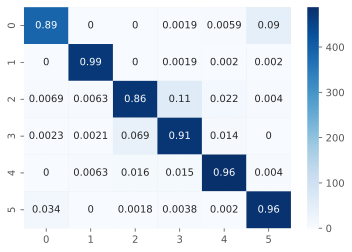

In [ ]:
print_confusion_matrix(np.array(y_true).argmax(axis=1), np.array(y_pred).argmax(axis=1))

The model gives about 93% accuracy.

#####v8m

In [ ]:
!yolo task=classify mode=train model=yolov8m-cls.pt data='/content/Classification_data' epochs=14 imgsz=150

100% 32.7M/32.7M [00:00<00:00, 75.2MB/s]
Ultralytics YOLOv8.0.119 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla V100-SXM2-16GB, 16151MiB)
yolo/engine/trainer: task=classify, mode=train, model=yolov8m-cls.pt, data=/content/Classification_data, epochs=14, patience=50, batch=16, imgsz=150, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=0, resume=False, amp=True, fraction=1.0, profile=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=

In [ ]:
_, y_pred, y_true = test_yolo('runs/classify/train4/weights/best.pt', '/content/Classification_data/test', labels)

Выходные данные были обрезаны до нескольких последних строк (5000).
image 1/1 /content/Classification_data/test/glacier/23098.jpg: 160x160 glacier 0.85, mountain 0.15, sea 0.00, street 0.00, forest 0.00, 4.9ms
Speed: 0.8ms preprocess, 4.9ms inference, 0.1ms postprocess per image at shape (1, 3, 160, 160)

image 1/1 /content/Classification_data/test/glacier/23096.jpg: 160x160 mountain 0.92, glacier 0.07, sea 0.00, forest 0.00, buildings 0.00, 5.3ms
Speed: 0.7ms preprocess, 5.3ms inference, 0.1ms postprocess per image at shape (1, 3, 160, 160)

image 1/1 /content/Classification_data/test/glacier/22829.jpg: 160x160 glacier 1.00, forest 0.00, mountain 0.00, street 0.00, sea 0.00, 5.2ms
Speed: 0.7ms preprocess, 5.2ms inference, 0.1ms postprocess per image at shape (1, 3, 160, 160)

image 1/1 /content/Classification_data/test/glacier/22500.jpg: 160x160 glacier 1.00, sea 0.00, mountain 0.00, buildings 0.00, street 0.00, 5.3ms
Speed: 0.8ms preprocess, 5.3ms inference, 0.1ms postprocess per ima

In [ ]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.90      0.92       437
           1       0.98      1.00      0.99       474
           2       0.92      0.87      0.89       553
           3       0.89      0.92      0.90       525
           4       0.96      0.97      0.96       510
           5       0.92      0.96      0.94       501

   micro avg       0.93      0.93      0.93      3000
   macro avg       0.93      0.93      0.93      3000
weighted avg       0.93      0.93      0.93      3000
 samples avg       0.93      0.93      0.93      3000



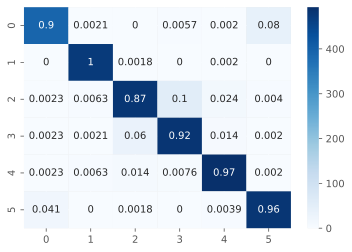

In [ ]:
print_confusion_matrix(np.array(y_true).argmax(axis=1), np.array(y_pred).argmax(axis=1))

The model gives about 93% accuracy.

#####v8s

In [ ]:
!yolo task=classify mode=train model=yolov8s-cls.pt data='/content/Classification_data' epochs=14 imgsz=150

100% 12.2M/12.2M [00:00<00:00, 77.1MB/s]
Ultralytics YOLOv8.0.119 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla V100-SXM2-16GB, 16151MiB)
yolo/engine/trainer: task=classify, mode=train, model=yolov8s-cls.pt, data=/content/Classification_data, epochs=14, patience=50, batch=16, imgsz=150, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=0, resume=False, amp=True, fraction=1.0, profile=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=

In [ ]:
_, y_pred, y_true = test_yolo('runs/classify/train3/weights/best.pt', '/content/Classification_data/test', labels)

Выходные данные были обрезаны до нескольких последних строк (5000).
image 1/1 /content/Classification_data/test/glacier/23098.jpg: 160x160 glacier 0.99, mountain 0.01, street 0.00, sea 0.00, buildings 0.00, 3.1ms
Speed: 0.7ms preprocess, 3.1ms inference, 0.1ms postprocess per image at shape (1, 3, 160, 160)

image 1/1 /content/Classification_data/test/glacier/23096.jpg: 160x160 mountain 1.00, glacier 0.00, forest 0.00, sea 0.00, buildings 0.00, 4.2ms
Speed: 0.7ms preprocess, 4.2ms inference, 0.1ms postprocess per image at shape (1, 3, 160, 160)

image 1/1 /content/Classification_data/test/glacier/22829.jpg: 160x160 glacier 1.00, forest 0.00, sea 0.00, street 0.00, mountain 0.00, 4.3ms
Speed: 0.9ms preprocess, 4.3ms inference, 0.1ms postprocess per image at shape (1, 3, 160, 160)

image 1/1 /content/Classification_data/test/glacier/22500.jpg: 160x160 glacier 1.00, mountain 0.00, sea 0.00, buildings 0.00, street 0.00, 4.0ms
Speed: 0.8ms preprocess, 4.0ms inference, 0.0ms postprocess per 

In [ ]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.92      0.93       437
           1       0.99      1.00      0.99       474
           2       0.90      0.86      0.88       553
           3       0.88      0.90      0.89       525
           4       0.95      0.97      0.96       510
           5       0.93      0.95      0.94       501

   micro avg       0.93      0.93      0.93      3000
   macro avg       0.93      0.93      0.93      3000
weighted avg       0.93      0.93      0.93      3000
 samples avg       0.93      0.93      0.93      3000



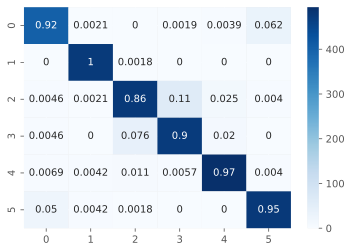

In [ ]:
print_confusion_matrix(np.array(y_true).argmax(axis=1), np.array(y_pred).argmax(axis=1))

The model gives about 93% accuracy.

####MobileNet

#####Frozen parameters

Let's first try MobileNet with frozen parameters.

In [ ]:
model = models.mobilenet_v2(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

num_features = model.classifier[1].in_features
model.classifier[1] = torch.nn.Linear(num_features, 6)

model = model.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

model, train_losses, train_accs, val_losses, val_accs = train_model(model, criterion, optimizer, scheduler, 12)

Epoch 0/11:


100%|██████████| 753/753 [00:17<00:00, 42.55it/s]

Train Loss: 1.0078



100%|██████████| 125/125 [00:03<00:00, 35.04it/s]

Val Loss: 0.5971
Epoch 1/11:



100%|██████████| 753/753 [00:16<00:00, 46.72it/s]

Train Loss: 0.5094



100%|██████████| 125/125 [00:03<00:00, 34.72it/s]

Val Loss: 0.4540
Epoch 2/11:



100%|██████████| 753/753 [00:16<00:00, 46.56it/s]

Train Loss: 0.4287



100%|██████████| 125/125 [00:03<00:00, 31.71it/s]

Val Loss: 0.4098
Epoch 3/11:



100%|██████████| 753/753 [00:16<00:00, 44.81it/s]

Train Loss: 0.3919



100%|██████████| 125/125 [00:03<00:00, 34.46it/s]

Val Loss: 0.3859
Epoch 4/11:



100%|██████████| 753/753 [00:16<00:00, 46.55it/s]

Train Loss: 0.3706



100%|██████████| 125/125 [00:03<00:00, 34.77it/s]

Val Loss: 0.3669
Epoch 5/11:



100%|██████████| 753/753 [00:16<00:00, 46.55it/s]

Train Loss: 0.3554



100%|██████████| 125/125 [00:04<00:00, 30.59it/s]

Val Loss: 0.3621
Epoch 6/11:



100%|██████████| 753/753 [00:16<00:00, 45.97it/s]

Train Loss: 0.3436



100%|██████████| 125/125 [00:03<00:00, 34.85it/s]

Val Loss: 0.3522
Epoch 7/11:



100%|██████████| 753/753 [00:16<00:00, 44.68it/s]

Train Loss: 0.3347



100%|██████████| 125/125 [00:03<00:00, 34.69it/s]

Val Loss: 0.3639
Epoch 8/11:



100%|██████████| 753/753 [00:16<00:00, 45.95it/s]

Train Loss: 0.3281



100%|██████████| 125/125 [00:04<00:00, 27.89it/s]

Val Loss: 0.3440
Epoch 9/11:



100%|██████████| 753/753 [00:16<00:00, 45.20it/s]

Train Loss: 0.3196



100%|██████████| 125/125 [00:03<00:00, 34.48it/s]

Val Loss: 0.3537
Epoch 10/11:



100%|██████████| 753/753 [00:16<00:00, 45.94it/s]

Train Loss: 0.3186



100%|██████████| 125/125 [00:03<00:00, 34.12it/s]

Val Loss: 0.3565
Epoch 11/11:



100%|██████████| 753/753 [00:16<00:00, 45.87it/s]

Train Loss: 0.3118



100%|██████████| 125/125 [00:04<00:00, 27.85it/s]

Val Loss: 0.3346


In [ ]:
y_true, y_pred = test_model(model, criterion)

100%|██████████| 188/188 [00:04<00:00, 44.55it/s]

Test Loss: 0.3031
              precision    recall  f1-score   support

           0       0.91      0.89      0.90       437
           1       0.99      0.99      0.99       474
           2       0.83      0.82      0.83       553
           3       0.84      0.81      0.82       525
           4       0.87      0.93      0.90       510
           5       0.92      0.91      0.91       501

    accuracy                           0.89      3000
   macro avg       0.89      0.89      0.89      3000
weighted avg       0.89      0.89      0.89      3000

[[389   1   0   1   9  37]
 [  0 467   3   3   1   0]
 [  2   3 456  61  30   1]
 [  2   1  74 423  24   1]
 [  2   1  16  15 473   3]
 [ 31   1   2   1   9 457]]


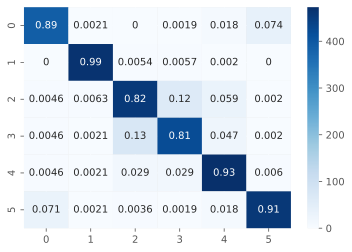

In [ ]:
print_confusion_matrix(y_true, y_pred)

The model gives about 89% accuracy.

#####3 frozen layers

In [ ]:
model = models.mobilenet_v2(pretrained=True)

num_layers_to_freeze = 3

for idx, param in enumerate(model.parameters()):
    if idx < num_layers_to_freeze:
        param.requires_grad = False

num_features = model.classifier[1].in_features
model.classifier[1] = torch.nn.Linear(num_features, 6)

model = model.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

model, train_losses, train_accs, val_losses, val_accs = train_model(model, criterion, optimizer, scheduler, 12)


Epoch 0/11:


100%|██████████| 753/753 [00:25<00:00, 29.02it/s]

Train Loss: 0.3983



100%|██████████| 125/125 [00:03<00:00, 33.98it/s]

Val Loss: 0.2253
Epoch 1/11:



100%|██████████| 753/753 [00:24<00:00, 31.26it/s]

Train Loss: 0.3080



100%|██████████| 125/125 [00:03<00:00, 32.65it/s]

Val Loss: 0.2626
Epoch 2/11:



100%|██████████| 753/753 [00:24<00:00, 31.33it/s]

Train Loss: 0.2316



100%|██████████| 125/125 [00:03<00:00, 33.44it/s]

Val Loss: 0.2327
Epoch 3/11:



100%|██████████| 753/753 [00:23<00:00, 31.46it/s]

Train Loss: 0.2074



100%|██████████| 125/125 [00:03<00:00, 31.41it/s]

Val Loss: 0.2335
Epoch 4/11:



100%|██████████| 753/753 [00:23<00:00, 31.46it/s]

Train Loss: 0.1826



100%|██████████| 125/125 [00:03<00:00, 31.55it/s]

Val Loss: 0.2237
Epoch 5/11:



100%|██████████| 753/753 [00:23<00:00, 31.67it/s]

Train Loss: 0.1638



100%|██████████| 125/125 [00:04<00:00, 30.38it/s]

Val Loss: 0.2431
Epoch 6/11:



100%|██████████| 753/753 [00:24<00:00, 31.35it/s]

Train Loss: 0.1566



100%|██████████| 125/125 [00:04<00:00, 29.94it/s]

Val Loss: 0.2631
Epoch 7/11:



100%|██████████| 753/753 [00:23<00:00, 31.60it/s]

Train Loss: 0.1472



100%|██████████| 125/125 [00:04<00:00, 28.88it/s]

Val Loss: 0.2366
Epoch 8/11:



100%|██████████| 753/753 [00:24<00:00, 31.36it/s]

Train Loss: 0.1365



100%|██████████| 125/125 [00:04<00:00, 29.81it/s]

Val Loss: 0.2104
Epoch 9/11:



100%|██████████| 753/753 [00:23<00:00, 31.42it/s]

Train Loss: 0.1224



100%|██████████| 125/125 [00:03<00:00, 31.49it/s]

Val Loss: 0.2593
Epoch 10/11:



100%|██████████| 753/753 [00:24<00:00, 31.06it/s]

Train Loss: 0.1172



100%|██████████| 125/125 [00:03<00:00, 32.63it/s]

Val Loss: 0.2720
Epoch 11/11:



100%|██████████| 753/753 [00:24<00:00, 31.36it/s]

Train Loss: 0.1175



100%|██████████| 125/125 [00:03<00:00, 33.19it/s]

Val Loss: 0.3071


In [ ]:
y_true, y_pred = test_model(model, criterion)

100%|██████████| 188/188 [00:03<00:00, 47.20it/s]

Test Loss: 0.2641
              precision    recall  f1-score   support

           0       0.84      0.97      0.90       437
           1       0.98      0.99      0.99       474
           2       0.90      0.87      0.88       553
           3       0.87      0.90      0.89       525
           4       0.96      0.94      0.95       510
           5       0.97      0.85      0.91       501

    accuracy                           0.92      3000
   macro avg       0.92      0.92      0.92      3000
weighted avg       0.92      0.92      0.92      3000

[[426   0   0   1   1   9]
 [  0 471   1   1   1   0]
 [  2   4 479  55  10   3]
 [  4   4  42 471   4   0]
 [  4   2  13  11 480   0]
 [ 71   0   0   0   2 428]]


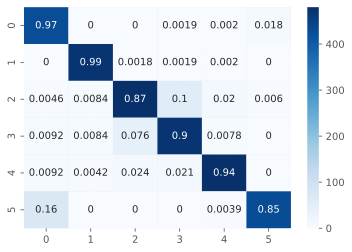

In [ ]:
print_confusion_matrix(y_true, y_pred)

The model gives about 92% accuracy.

#####Unfrozen parameters

In [ ]:
model = models.mobilenet_v2(pretrained=True)

num_features = model.classifier[1].in_features
model.classifier[1] = torch.nn.Linear(num_features, 6)

model = model.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

model, train_losses, train_accs, val_losses, val_accs = train_model(model, criterion, optimizer, scheduler, 12)


Epoch 0/11:


100%|██████████| 753/753 [00:28<00:00, 26.36it/s]

Train Loss: 0.4070



100%|██████████| 125/125 [00:03<00:00, 34.21it/s]

Val Loss: 0.2659
Epoch 1/11:



100%|██████████| 753/753 [00:25<00:00, 29.97it/s]

Train Loss: 0.3070



100%|██████████| 125/125 [00:03<00:00, 34.24it/s]

Val Loss: 0.2460
Epoch 2/11:



100%|██████████| 753/753 [00:25<00:00, 29.57it/s]

Train Loss: 0.2277



100%|██████████| 125/125 [00:03<00:00, 34.16it/s]

Val Loss: 0.2526
Epoch 3/11:



100%|██████████| 753/753 [00:25<00:00, 29.85it/s]

Train Loss: 0.1999



100%|██████████| 125/125 [00:03<00:00, 34.32it/s]

Val Loss: 0.2469
Epoch 4/11:



100%|██████████| 753/753 [00:25<00:00, 29.65it/s]

Train Loss: 0.1865



100%|██████████| 125/125 [00:03<00:00, 34.39it/s]

Val Loss: 0.2527
Epoch 5/11:



100%|██████████| 753/753 [00:25<00:00, 29.87it/s]

Train Loss: 0.1661



100%|██████████| 125/125 [00:03<00:00, 34.67it/s]

Val Loss: 0.2309
Epoch 6/11:



100%|██████████| 753/753 [00:25<00:00, 29.98it/s]

Train Loss: 0.1586



100%|██████████| 125/125 [00:03<00:00, 35.24it/s]

Val Loss: 0.3126
Epoch 7/11:



100%|██████████| 753/753 [00:25<00:00, 29.71it/s]

Train Loss: 0.1462



100%|██████████| 125/125 [00:03<00:00, 34.44it/s]

Val Loss: 0.2736
Epoch 8/11:



100%|██████████| 753/753 [00:27<00:00, 26.93it/s]

Train Loss: 0.1394



100%|██████████| 125/125 [00:03<00:00, 34.53it/s]

Val Loss: 0.2593
Epoch 9/11:



100%|██████████| 753/753 [00:25<00:00, 29.51it/s]

Train Loss: 0.1266



100%|██████████| 125/125 [00:03<00:00, 35.10it/s]

Val Loss: 0.2783
Epoch 10/11:



100%|██████████| 753/753 [00:25<00:00, 29.39it/s]

Train Loss: 0.1196



100%|██████████| 125/125 [00:03<00:00, 33.22it/s]

Val Loss: 0.3812
Epoch 11/11:



100%|██████████| 753/753 [00:25<00:00, 29.81it/s]

Train Loss: 0.1057



100%|██████████| 125/125 [00:04<00:00, 31.09it/s]

Val Loss: 0.2709


In [ ]:
y_true, y_pred = test_model(model, criterion)

100%|██████████| 188/188 [00:05<00:00, 35.87it/s]

Test Loss: 0.2656
              precision    recall  f1-score   support

           0       0.96      0.92      0.94       437
           1       0.99      0.97      0.98       474
           2       0.84      0.91      0.87       553
           3       0.91      0.84      0.87       525
           4       0.94      0.96      0.95       510
           5       0.93      0.96      0.94       501

    accuracy                           0.92      3000
   macro avg       0.93      0.93      0.93      3000
weighted avg       0.93      0.92      0.92      3000

[[401   0   0   0   2  34]
 [  0 462   9   3   0   0]
 [  1   1 502  33  14   2]
 [  0   1  73 439  11   1]
 [  0   1  15   3 490   1]
 [ 16   0   0   2   3 480]]


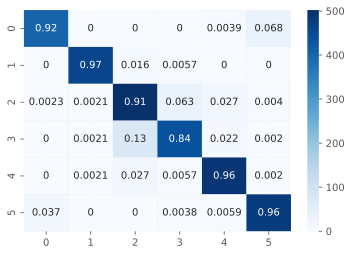

In [ ]:
print_confusion_matrix(y_true, y_pred)

The accuracy of the model is 93%.

#Conclusions

SVM with classical features provides the worst results among the considered models. SVM relies on handcrafted features, which may not capture some patterns in the data as effectively as deep learning models. The custom CNN model, as expected, provides better results compared to SVM with classical features. It is able to capture more complex patterns and relationships. The pretrained models (ResNet, YOLO and MobileNet) performed better than others since they have been trained on large-scale datasets and provide complex feature extraction capabilities. Among MobileNet models, the one with unfrozen parameters turned out to give higher accuracy. YOLO models and MobileNet with unfrozen parameters showed the highest accuracy of 93%.